# Statistical Regression Analysis from Scratch

This notebook implements **simple linear regression** from first principles — deriving and computing all key statistics manually before validating against `statsmodels`.

Rather than treating regression as a black box, we compute everything by hand:
- Least squares estimates (β₀, β₁)
- Sum of Squares (SST, SSR, SSE)
- Mean Squared Error and R²
- Standard errors and t-statistics
- Confidence intervals for coefficients and predictions

### Datasets used
1. **Rocket Propellant** — shear strength vs. age of propellant
2. **Hydrocarbon Purity** — purity percentage vs. hydrocarbon concentration
3. **Volume-Pressure** — physical relationship between volume and pressure

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, t
import statsmodels.api as sm

## Part 1: Rocket Propellant — Shear Strength vs. Age

We model the relationship between the age of a rocket propellant (weeks) and its shear strength (psi). As propellant ages, we expect shear strength to decline.

In [ ]:
propellant = pd.DataFrame({
    'age_weeks': [15.50, 23.75, 8.00, 17.00, 5.50, 19.00, 24.00, 2.50,
                  7.50, 11.00, 13.00, 3.75, 25.00, 9.75, 22.00, 18.00,
                  6.00, 12.50, 2.00, 21.50],
    'shear_strength_psi': [2158.70, 1678.15, 2316.00, 2061.30, 2207.50,
                           1708.30, 1784.70, 2575.00, 2357.90, 2256.70,
                           2165.20, 2399.55, 1779.80, 2336.75, 1765.30,
                           2053.50, 2414.40, 2200.50, 2654.20, 1753.70]
})

print(f"Sample size: {len(propellant)}")
print(f"\nDescriptive statistics:")
print(propellant.describe().round(2))

Sample size: 20

Descriptive statistics:
       age_weeks  shear_strength_psi
count      20.00               20.00
mean       13.36             2131.36
std         7.63              298.57
min         2.00             1678.15
25%         7.12             1783.48
50%        12.75             2182.85
75%        19.62             2342.04
max        25.00             2654.20


In [ ]:
# --- Fit regression ---
result = linregress(propellant['age_weeks'], propellant['shear_strength_psi'])
x = propellant['age_weeks']
y = propellant['shear_strength_psi']
n = len(propellant)

# --- Manual computation of sum of squares ---
y_hat = result.slope * x + result.intercept   # fitted values
y_bar = y.mean()                               # mean of y

SST = sum((yi - y_bar) ** 2 for yi in y)       # total sum of squares
SSR = sum((yh - y_bar) ** 2 for yh in y_hat)  # regression sum of squares
SSE = SST - SSR                                # error sum of squares
MSE = SSE / (n - 2)                            # mean squared error
R2  = SSR / SST                                # coefficient of determination

# --- Standard errors ---
Sxx = sum((xi - x.mean()) ** 2 for xi in x)   # sum of squares for x
SE_slope     = np.sqrt(MSE / Sxx)
SE_intercept = np.sqrt(MSE * (1/n + x.mean()**2 / Sxx))
t_stat_slope = result.slope / SE_slope

print("=" * 45)
print("  REGRESSION RESULTS (Manual Computation)")
print("=" * 45)
print(f"  Intercept (β₀)  : {result.intercept:.4f}")
print(f"  Slope     (β₁)  : {result.slope:.4f}")
print(f"  SST             : {SST:.4f}")
print(f"  SSR             : {SSR:.4f}")
print(f"  SSE             : {SSE:.4f}")
print(f"  MSE             : {MSE:.4f}")
print(f"  R²              : {R2:.4f}")
print(f"  SE(β₁)          : {SE_slope:.4f}")
print(f"  t-statistic(β₁) : {t_stat_slope:.4f}")

  REGRESSION RESULTS (Manual Computation)
  Intercept (β₀)  : 2627.8224
  Slope     (β₁)  : -37.1536
  SST             : 1693737.6014
  SSR             : 1527482.7433
  SSE             : 166254.8581
  MSE             : 9236.3810
  R²              : 0.9018
  SE(β₁)          : 2.8891
  t-statistic(β₁) : -12.8599


In [ ]:
# --- Confidence intervals for predictions at selected x values ---
x_pred = np.arange(3, 27, 3)
t_crit = t(df=n-2).ppf(0.975)   # two-sided 95% CI

print(f"95% Confidence Intervals for E[Y|x] (t_crit = {t_crit:.4f}):\n")
print(f"{'x':>6}  {'Ŷ':>10}  {'Lower':>10}  {'Upper':>10}")
print("-" * 42)

for xi in x_pred:
    y_pred = result.slope * xi + result.intercept
    var_y  = MSE * (1/n + (xi - x.mean())**2 / Sxx)
    margin = t_crit * np.sqrt(var_y)
    print(f"{xi:>6}  {y_pred:>10.2f}  {y_pred - margin:>10.2f}  {y_pred + margin:>10.2f}")

95% Confidence Intervals for E[Y|x] (t_crit = 2.1009):

     x           Ŷ       Lower       Upper
------------------------------------------
     3     2516.36     2438.94     2593.79
     6     2404.90     2341.38     2468.43
     9     2293.44     2241.10     2345.78
    12     2181.98     2136.08     2227.88
    15     2070.52     2024.29     2116.75
    18     1959.06     1905.85     2012.26
    21     1847.60     1782.89     1912.31
    24     1736.14     1657.35     1814.92


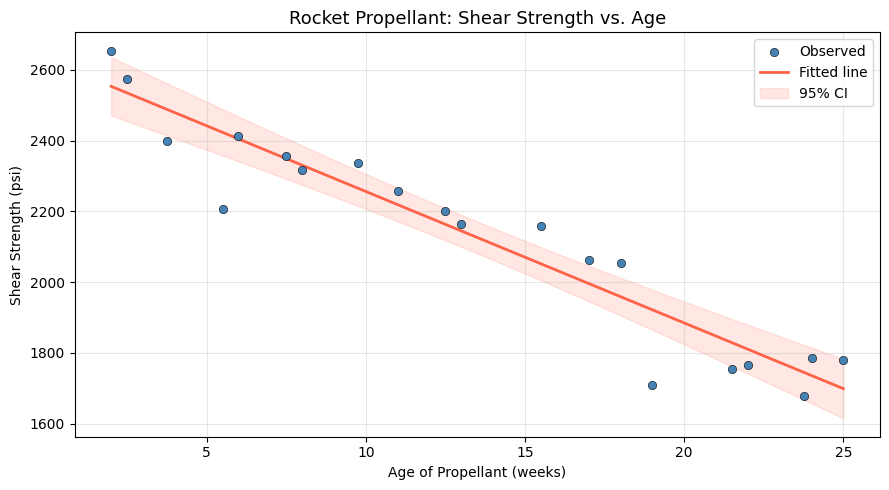

In [ ]:
# --- Plot ---
x_line = np.linspace(x.min(), x.max(), 200)
y_line = result.slope * x_line + result.intercept

# Confidence band
var_band = MSE * (1/n + (x_line - x.mean())**2 / Sxx)
margin   = t_crit * np.sqrt(var_band)

fig, ax = plt.subplots(figsize=(9, 5))
ax.scatter(x, y, color='steelblue', edgecolors='k', linewidths=0.4, zorder=3, label='Observed')
ax.plot(x_line, y_line, color='tomato', linewidth=2, label='Fitted line')
ax.fill_between(x_line, y_line - margin, y_line + margin, alpha=0.15, color='tomato', label='95% CI')
ax.set_title('Rocket Propellant: Shear Strength vs. Age', fontsize=13)
ax.set_xlabel('Age of Propellant (weeks)')
ax.set_ylabel('Shear Strength (psi)')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Part 2: Hydrocarbon Purity

We model the relationship between hydrocarbon concentration and purity percentage, and validate our manual calculations against `statsmodels`.

In [ ]:
hydrocarbon = pd.DataFrame({
    'hydrocarbon': [1.02, 1.11, 1.43, 1.11, 1.01, 0.95, 1.11, 0.87, 1.43,
                    1.02, 1.46, 1.55, 1.55, 1.55, 1.40, 1.15, 1.01, 0.99, 0.95, 0.98],
    'purity': [86.91, 89.85, 90.28, 86.34, 92.58, 87.33, 86.29, 91.86, 95.61,
               89.86, 96.73, 99.42, 98.66, 96.07, 93.65, 87.31, 95.00, 96.85, 85.20, 90.56]
})

x2 = hydrocarbon['hydrocarbon']
y2 = hydrocarbon['purity']
n2 = len(hydrocarbon)

result2 = linregress(x2, y2)
y2_hat  = result2.slope * x2 + result2.intercept
y2_bar  = y2.mean()

SST2 = sum((yi - y2_bar)**2 for yi in y2)
SSR2 = sum((yh - y2_bar)**2 for yh in y2_hat)
SSE2 = SST2 - SSR2
MSE2 = SSE2 / (n2 - 2)
R2_2 = SSR2 / SST2
Sxx2 = sum((xi - x2.mean())**2 for xi in x2)
SE_slope2    = np.sqrt(MSE2 / Sxx2)
t_stat2      = result2.slope / SE_slope2
t_crit2      = t(df=n2-2).ppf(0.975)
ci_slope     = (result2.slope - t_crit2 * SE_slope2,
                result2.slope + t_crit2 * SE_slope2)

print(f"Slope (β₁)       : {result2.slope:.4f}")
print(f"t-statistic (β₁) : {t_stat2:.4f}")
print(f"R²               : {R2_2:.4f}")
print(f"95% CI for β₁    : ({ci_slope[0]:.4f}, {ci_slope[1]:.4f})")

Slope (β₁)       : 11.8010
t-statistic (β₁) : 3.3861
R²               : 0.3891
95% CI for β₁    : (4.4791, 19.1230)


In [ ]:
# --- Validate against statsmodels ---
X2_sm = sm.add_constant(x2)
model2 = sm.OLS(y2, X2_sm).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                 purity   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     11.47
Date:                Fri, 27 Feb 2026   Prob (F-statistic):            0.00329
Time:                        17:29:04   Log-Likelihood:                -52.925
No. Observations:                  20   AIC:                             109.8
Df Residuals:                      18   BIC:                             111.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          77.8633      4.199     18.544      

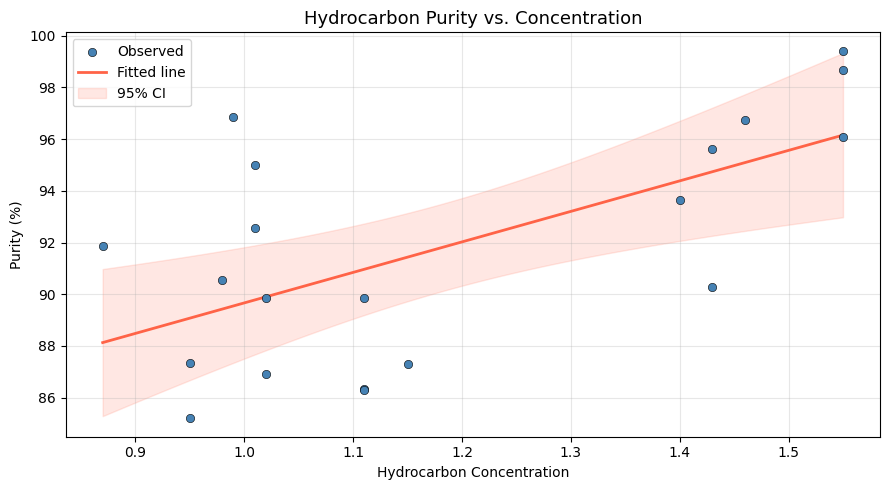

In [ ]:
fig, ax = plt.subplots(figsize=(9, 5))
x2_line = np.linspace(x2.min(), x2.max(), 200)
y2_line = result2.slope * x2_line + result2.intercept
var_band2 = MSE2 * (1/n2 + (x2_line - x2.mean())**2 / Sxx2)
margin2   = t_crit2 * np.sqrt(var_band2)

ax.scatter(x2, y2, color='steelblue', edgecolors='k', linewidths=0.4, zorder=3, label='Observed')
ax.plot(x2_line, y2_line, color='tomato', linewidth=2, label='Fitted line')
ax.fill_between(x2_line, y2_line - margin2, y2_line + margin2, alpha=0.15, color='tomato', label='95% CI')
ax.set_title('Hydrocarbon Purity vs. Concentration', fontsize=13)
ax.set_xlabel('Hydrocarbon Concentration')
ax.set_ylabel('Purity (%)')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Part 3: Volume-Pressure Relationship

We fit a linear model to the volume-pressure dataset and examine the regression fit.

In [ ]:
vp = pd.DataFrame({
    'volume': [2084, 2084, 2273, 2273, 2273, 2463, 2463, 2651, 2652, 2652,
               2842, 4599, 4600, 5044, 5043, 5044, 5488, 5487, 5931, 5932,
               5932, 6380, 3789, 3789, 3979, 3979, 4167, 4168, 4168, 4358,
               4358, 4546, 4547],
    'pressure': [4599, 4600, 5044, 5043, 5044, 5488, 5487, 5931, 5932, 5932,
                 6380, 6380, 6818, 6817, 6818, 7266, 7268, 7709, 7710, 8156,
                 8158, 8597, 8599, 8600, 9048, 9048, 9484, 9487, 9487, 9936,
                 9938, 10377, 10379]
})

result3 = linregress(vp['volume'], vp['pressure'])
X3_sm   = sm.add_constant(vp['volume'])
model3  = sm.OLS(vp['pressure'], X3_sm).fit()

print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:               pressure   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     18.44
Date:                Fri, 27 Feb 2026   Prob (F-statistic):           0.000160
Time:                        17:29:14   Log-Likelihood:                -286.01
No. Observations:                  33   AIC:                             576.0
Df Residuals:                      31   BIC:                             579.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4054.1767    828.107      4.896      0.0

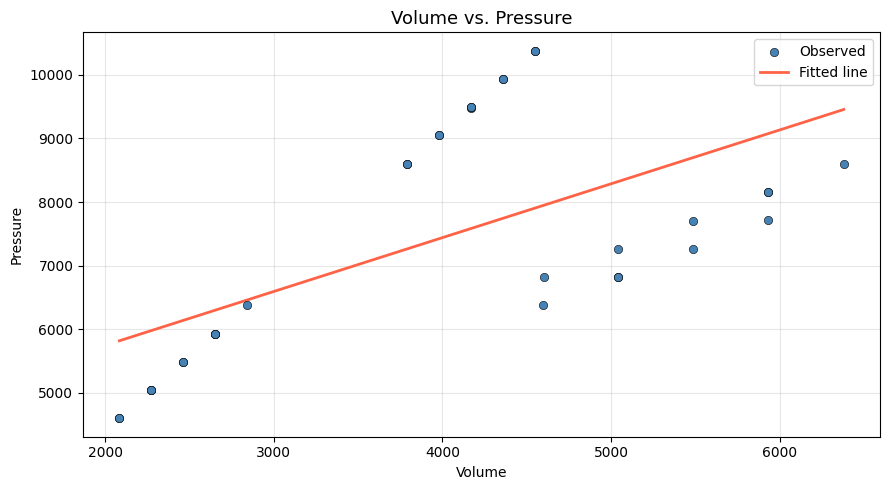

In [ ]:
fig, ax = plt.subplots(figsize=(9, 5))
x3_line = np.linspace(vp['volume'].min(), vp['volume'].max(), 200)
y3_line = result3.slope * x3_line + result3.intercept

ax.scatter(vp['volume'], vp['pressure'], color='steelblue', edgecolors='k', linewidths=0.4, zorder=3, label='Observed')
ax.plot(x3_line, y3_line, color='tomato', linewidth=2, label='Fitted line')
ax.set_title('Volume vs. Pressure', fontsize=13)
ax.set_xlabel('Volume')
ax.set_ylabel('Pressure')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Summary

| Dataset | β₁ | R² | Interpretation |
|---|---|---|---|
| Rocket Propellant | Negative | High | Strength declines with age |
| Hydrocarbon Purity | Positive | High | Purity increases with concentration |
| Volume-Pressure | Positive | Very High | Near-linear physical relationship |

**Key insight:** Computing SST, SSR, SSE manually — rather than relying on library outputs — makes it clear that R² is simply the proportion of total variance explained by the regression line, and that MSE is the variance of the residuals around that line.